<a href="https://colab.research.google.com/github/tnptw/tuberculosis-detection/blob/main/tuberculosis_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Notebook Setup and Import**

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.1 MB/s 
     |████████████████████████████████| 189 kB 37.0 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 39.0 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 51 kB 339 kB/s 
Mounted at /content/gdrive


In [2]:
import numpy as np 
import pandas as pd 
import cv2
import imageio
import io
import shutil
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff
from PIL import Image
import requests
from io import BytesIO
from fastai.vision.all import *
%matplotlib inline
import os
from fastbook import *
from fastai.vision.widgets import *

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Create the Training Set**

In [5]:
path = "/content/gdrive/MyDrive/tuberculosis_chest_x-rays/images_train" #image folder path

def is_tuberculosis(x): return x[12] == '1'
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_tuberculosis, item_tfms=Resize(224))

print(len(dls.train_ds.items[:])) # Amount of training set

476


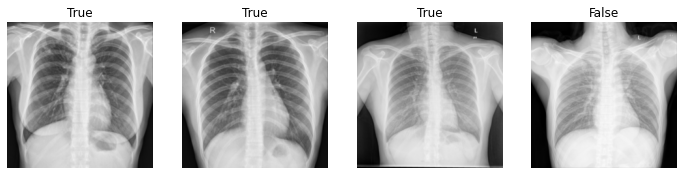

In [7]:
dls.train.show_batch(max_n=4, nrows=1)

In [9]:
def label_func(x):
    return "True" if x.name[12] == '1' else "False"

dtb = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func,
    item_tfms=Resize(224))

dls = dtb.dataloaders(path)

## **Data Augmentation**


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning:

torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)



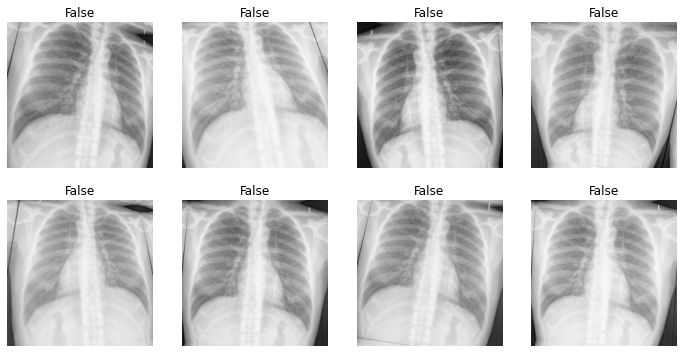

In [10]:
dtb = dtb.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=1))
dls = dtb.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## **Training the Model**

In [11]:
learn = cnn_learner(dls, resnet50, metrics=[accuracy, Precision(), Recall(), F1Score()]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

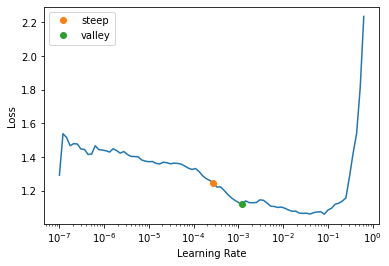

In [12]:
lrs = learn.lr_find(suggest_funcs=(steep, valley))

In [13]:
lrs.steep

0.0002754228771664202

In [14]:
lrs.valley

0.0012022644514217973

In [15]:
learn.fit_one_cycle(3,0.0012022644514217973)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.213547,1.175454,0.630252,1.000000,0.200000,0.333333,02:47
1,1.009634,0.982032,0.689076,0.821429,0.418182,0.554217,01:26
2,0.901562,1.141157,0.680672,0.814815,0.400000,0.536585,01:26


In [16]:
learn.unfreeze()

SuggestedLRs(valley=0.00010964782268274575)

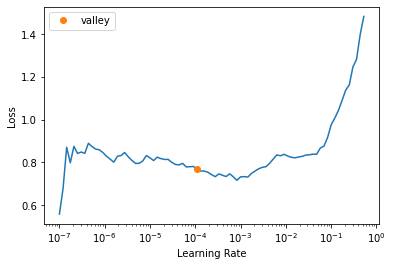

In [17]:
learn.lr_find()

In [18]:
learn.fine_tune(epochs=10,
          base_lr=0.00010964782268274575,
          freeze_epochs=1, #how many epochs to train frozen
          lr_mult=100, #train feature extractor with max lr at base_lr/lr_mult
          pct_start=0.3, #start decreasing lr at 
          div=5.0, #start at base_lr (max lr) / div
          cbs=[SaveModelCallback(monitor='f1_score')] # Save Best model
          )

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.845795,1.130200,0.680672,0.774194,0.436364,0.558140,01:26


Better model found at epoch 0 with f1_score value: 0.5581395348837209.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.972085,1.097265,0.739496,0.852941,0.527273,0.651685,01:26
1,0.908097,0.984938,0.747899,0.837838,0.563636,0.673913,01:27
2,0.880335,0.838578,0.747899,0.837838,0.563636,0.673913,01:28
3,0.820658,0.726294,0.756303,0.782609,0.654545,0.712871,01:28
4,0.803960,0.654580,0.823529,0.826923,0.781818,0.803738,01:27
5,0.753689,0.632514,0.831933,0.843137,0.781818,0.811321,01:28
6,0.705409,0.601572,0.831933,0.843137,0.781818,0.811321,01:28
7,0.698654,0.614369,0.815126,0.836735,0.745455,0.788462,01:28
8,0.672581,0.627468,0.815126,0.836735,0.745455,0.788462,01:27
9,0.667652,0.630433,0.823529,0.840000,0.763636,0.800000,01:26


Better model found at epoch 0 with f1_score value: 0.6516853932584269.
Better model found at epoch 1 with f1_score value: 0.6739130434782609.
Better model found at epoch 3 with f1_score value: 0.7128712871287128.
Better model found at epoch 4 with f1_score value: 0.8037383177570092.
Better model found at epoch 5 with f1_score value: 0.8113207547169811.


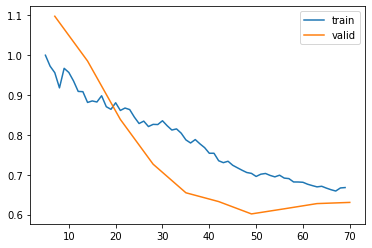

In [19]:
learn.recorder.plot_loss()

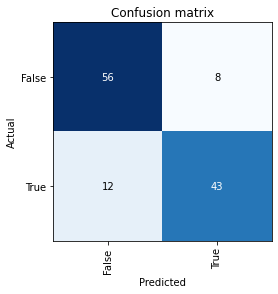

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## **Perform on the Test Set**

In [21]:
def label_func(x):
    return "True" if x.name[12] == '1' else "False"

dtb = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func,
    item_tfms=Resize(224))

testpath = "/content/gdrive/MyDrive/tuberculosis_chest_x-rays/images_test" #image folder path
dls = dtb.dataloaders(testpath)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics=[accuracy, Precision(), Recall(), F1Score()]).to_fp16()
#load trained model
learn.load('model');

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning:

Saved filed doesn't contain an optimizer state.



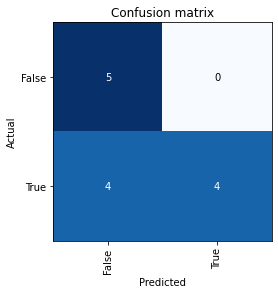

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [23]:
interp.print_classification_report()

              precision    recall  f1-score   support

       False       0.56      1.00      0.71         5
        True       1.00      0.50      0.67         8

    accuracy                           0.69        13
   macro avg       0.78      0.75      0.69        13
weighted avg       0.83      0.69      0.68        13

